In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess

# %matplotlib notebook
%matplotlib inline

In [2]:
def barabasi_albert(n=10, m=4):
    G = nx.barabasi_albert_graph(n, m)
    G.graph["dissemination"] = "flooding"
    # compute power
    solving_rate = np.random.exponential(n, n).astype("d")
    for i in range(n):
        G.nodes[i]["compute"] = solving_rate[i] / np.sum(solving_rate)
    # edge distances
    n_edges = len(G.edges)
    distance = np.random.uniform(low=1, high=3, size=n_edges)
    for (a, b) in G.edges:
        G.edges[a, b]["distance"] = distance[i]
        G.edges[a, b]["delay"] = f"uniform {distance[i] * 0.5} {distance[i] * 1.5}"
        G.edges[a, b]["spring_weight"] = 1 / distance[i]
    distances = dict(nx.shortest_path_length(G, weight="distance"))
    # closeness / farness metrics
    node_attr = dict()
    for i, d in distances.items():
        farness = sum(d.values()) / (n - 1)
        compute_farness = sum([G.nodes[j]["compute"] * d for j, d in d.items()])
        node_attr[i] = dict(
            farness=farness,
            closeness=1 / farness,
            compute_farness=compute_farness,
            compute_closeness=1 / compute_farness,
        )
    nx.set_node_attributes(G, node_attr)
    # done
    return G


def sim(G, protocol="nakamoto", activation_delay=1, activations=1000):
    G = G.copy()
    G.graph["activation_delay"] = activation_delay
    G.graph["activations"] = activations
    G.graph["protocol"] = protocol
    with subprocess.Popen(
        ["dune", "exec", "ocaml/bin/igraph_runner.exe"],
        cwd="../..",
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        text=True,
    ) as process:
        for line in nx.generate_graphml(G):
            try:
                process.stdin.write(line)
            except BrokenPipeError as e:
                pass
        out, err = process.communicate()
        return nx.parse_graphml(out)


def draw(G, size="compute", layout=None):
    G = G.copy()
    size = nx.get_node_attributes(G, size).values()
    size = np.array(list(size)) * 1000
    size = np.interp(size, (size.min(), size.max()), (100, 2000))
    return_layout = False
    if not layout:
        layout = nx.spring_layout(G, weight="spring_weight")
        return_layout = True
    nx.draw(G, pos=layout, node_size=size)
    if return_layout:
        return layout


def print_(G):
    for l in nx.generate_graphml(G):
        print(l)

In [3]:
G = barabasi_albert(n=7)
pd.DataFrame.from_dict(G.nodes, orient="index")

,compute,farness,closeness,compute_farness,compute_closeness
0,0.169983,2.834240,0.352828,2.352468,0.425085
1,0.253729,4.251360,0.235219,3.520693,0.284035
2,0.007008,4.723733,0.211697,4.945635,0.202198
3,0.203394,4.723733,0.211697,4.007363,0.249541
4,0.285527,4.723733,0.211697,3.541794,0.282343
5,0.009319,3.306613,0.302424,2.827691,0.353645
6,0.071041,3.778987,0.264621,4.018611,0.248842


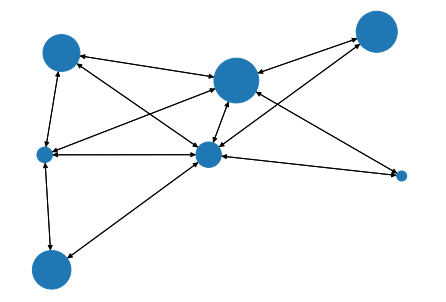

In [4]:
G = sim(barabasi_albert(n=7), activation_delay=1, activations=10000)
layout = draw(G)

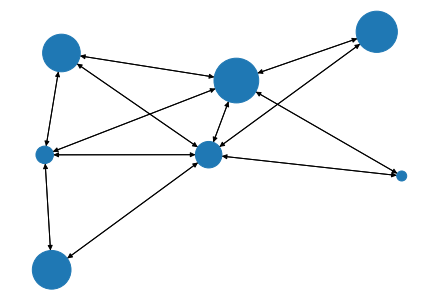

In [5]:
draw(G, size="activations", layout=layout)

In [6]:
runs = []
for _ in range(10):
    net = barabasi_albert(n=7)
    cf = dict(G.nodes(data="compute_farness")).values()
    est_progagation_delay = sum(cf) / len(cf)
    for p in ["nakamoto", "ethereum", "tailstorm 8 constant", "tailstorm 8 discount"]:
        G = sim(
            net,
            activation_delay=2 * est_progagation_delay,
            activations=1000,
            protocol=p,
        )
        d = pd.DataFrame.from_dict(G.nodes, orient="index")
        d["protocol"] = p
        runs.append(d)
df = pd.concat(runs)
# calculate metrics
df["relative_reward"] = df.reward / np.sum(df.reward)
df["relative_activations"] = df.reward / np.sum(df.activations)
df["efficiency"] = df.reward / G.graph["head_progress"] / df.compute
df.efficiency.fillna(0, inplace=True)
display(df)

,activations,reward,compute_closeness,compute_farness,closeness,farness,compute,protocol,relative_reward,relative_activations,efficiency
n0,32.0,24.000,0.491025,2.036555,0.472140,2.118017,0.038461,nakamoto,0.000722,0.000600,0.757287
n1,428.0,379.000,0.518648,1.928091,0.314760,3.177025,0.422346,nakamoto,0.011409,0.009475,1.089039
n2,23.0,9.000,0.275675,3.627459,0.314760,3.177025,0.021177,nakamoto,0.000271,0.000225,0.515774
n3,114.0,71.000,0.295009,3.389724,0.283284,3.530028,0.120711,nakamoto,0.002137,0.001775,0.713812
n4,193.0,108.000,0.298829,3.346392,0.257531,3.883031,0.190787,nakamoto,0.003251,0.002700,0.686986
...,...,...,...,...,...,...,...,...,...,...,...
n2,38.0,14.875,0.229266,4.361745,0.212838,4.698416,0.036163,tailstorm 8 discount,0.000448,0.000372,0.499192
n3,87.0,43.750,0.267514,3.738117,0.236486,4.228574,0.078624,tailstorm 8 discount,0.001317,0.001094,0.675294
n4,247.0,157.625,0.372524,2.684392,0.236486,4.228574,0.265518,tailstorm 8 discount,0.004745,0.003941,0.720450
n5,61.0,33.375,0.341917,2.924686,0.304054,3.288891,0.065491,tailstorm 8 discount,0.001005,0.000834,0.618458


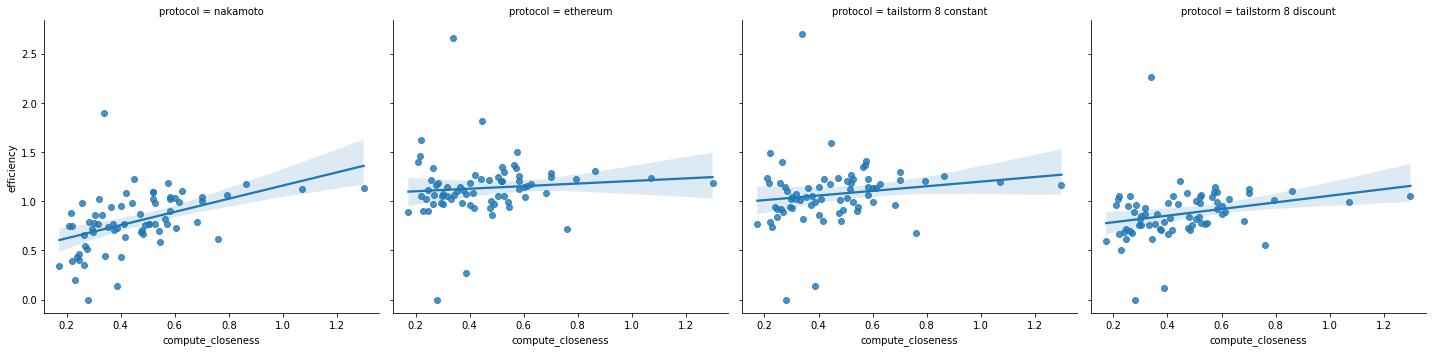

In [7]:
sns.lmplot(data=df, x="compute_closeness", y="efficiency", col="protocol")

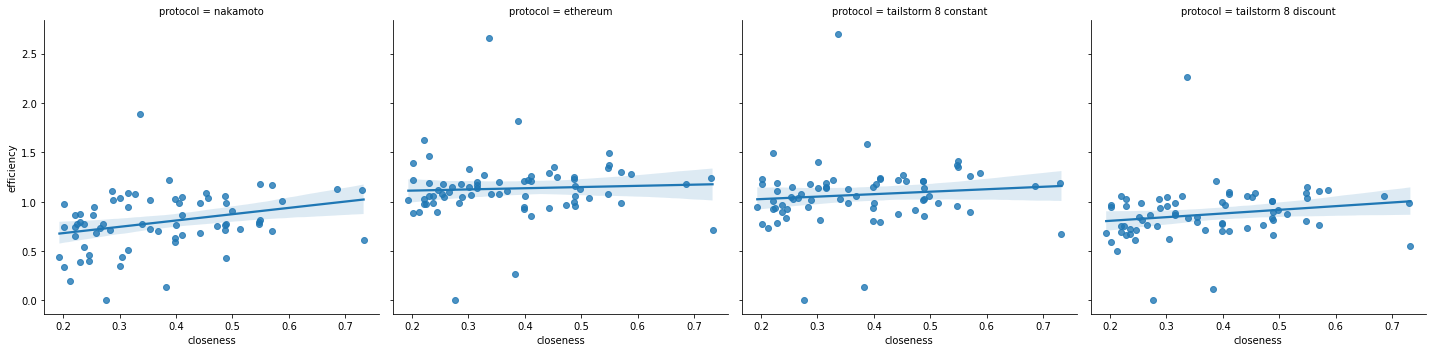

In [8]:
sns.lmplot(data=df, x="closeness", y="efficiency", col="protocol")